In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import powerlaw
from tree import Tree
from fire import Fire
from forest import Forest
from analysis import Analyse
from forest_sim import run_simulation, initialize_forest


Total time taken: 0.79 seconds


In [2]:
L = 50
g = 1
f = 50
timesteps = 2000
instances = 1
freeze_time_during_fire = True
remember_history = False

analysis_exp =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances)
analysis_exp.run_one_instance()

analysis_exp.animate('animation')

In [3]:
print(analysis_exp.find_proportion_power_law())
analysis_exp.log_log_plot()

In [4]:
analysis_exp.proportion_power_law


In [5]:
L = 100
g = 1
f = 50
timesteps = 10**5
instances = 10
freeze_time_during_fire = True
remember_history = False

analysis_exp =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances)
analysis_exp.run_all()
print(analysis_exp.find_proportion_power_law())
analysis_exp.log_log_plot(3)

[91 85]


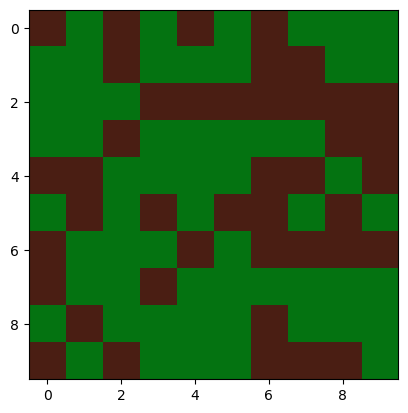

In [6]:
analysis_exp.proportion_power_law

Ilia Simulation data analysis

In [7]:
# Parameters
size: tuple = (50, 50) 
tree_density: float = 0.01
iterations: int = 50000
fire_start: tuple = (250, 250)
growth_prob: float = 0.001
ortho_burn_prob: float = 0.8
diag_burn_prob: float = 0.8
lightning_prob: float = 0.0001 
FireLength: int  = 0
arrayOfFireLengths: list[int] = []
forest = initialize_forest(size=size, tree_density=tree_density) 

In [8]:
FireLength, arrayOfFireLengths  = run_simulation(size=size, tree_density=tree_density, iterations=iterations, fire_start=fire_start, growth_prob=growth_prob, lightning_prob=lightning_prob, ortho_burn_prob=ortho_burn_prob, diag_burn_prob=diag_burn_prob, FireLength=FireLength, arrayOfFireLengths=arrayOfFireLengths)


Total time taken: 8.37 seconds


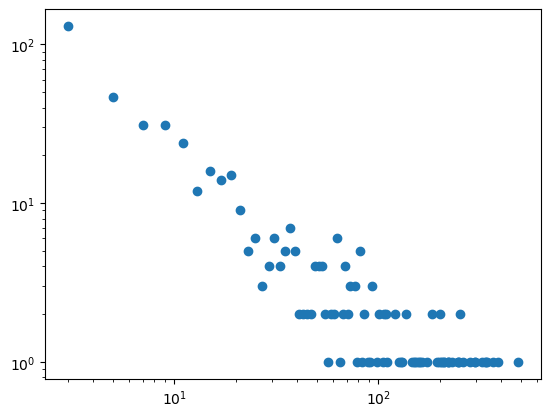

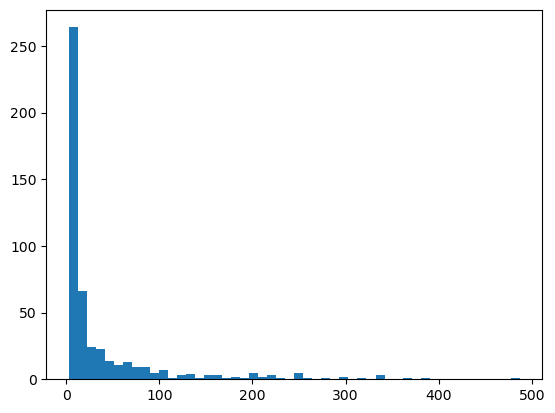

Calculating best minimal value for power law fit
2.2167705894256535
49.0
1.7981963343024336 0.00033062392139399967


In [4]:
y = np.bincount(arrayOfFireLengths)
x = np.nonzero(a=y)[0]
plt.scatter(x=x, y=y[x])
plt.xscale(value='log')
plt.yscale(value='log')
plt.show()
plt.hist(arrayOfFireLengths, bins=50)
plt.show()
results = powerlaw.Fit(data=arrayOfFireLengths)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare(dist1='truncated_power_law', dist2='lognormal')
print(R, p)

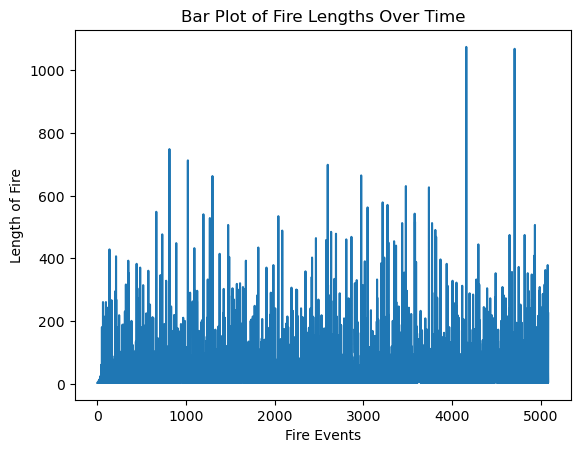

In [22]:
unique_identifiers = range(len(arrayOfFireLengths))
plt.plot(unique_identifiers, arrayOfFireLengths)

plt.xlabel('Fire Events')
plt.ylabel('Length of Fire')
plt.title('Bar Plot of Fire Lengths Over Time')

plt.show()

In [23]:
print(max(arrayOfFireLengths))

1075


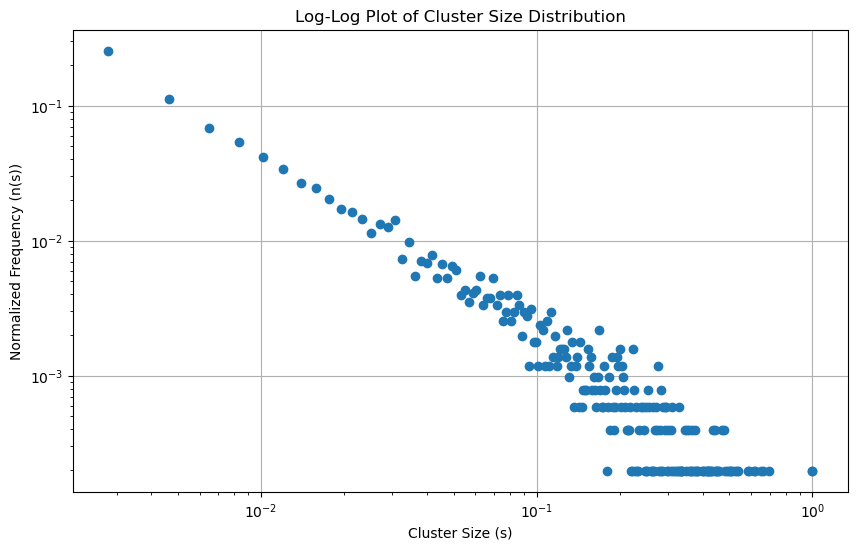

In [29]:
# Total number of clusters
from collections import Counter


total_clusters = len(arrayOfFireLengths)
frequency_distribution = Counter(arrayOfFireLengths)
# Normalizing by the total number of clusters
n_s_clusters = {s: freq / total_clusters for s, freq in frequency_distribution.items()}


# Normalizing by the total number of sites
# n_s_sites = {s: freq / total_sites for s, freq in frequency_distribution.items()}
# Prepare data for plotting
cluster_sizes = np.array(list(n_s_clusters.keys()))/max(arrayOfFireLengths)
frequencies = np.array(list(n_s_clusters.values()))

# Filter out zero frequencies for log-log plot
nonzero_indices = frequencies > 0
cluster_sizes = cluster_sizes[nonzero_indices]
frequencies = frequencies[nonzero_indices]

# Create a log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(cluster_sizes, frequencies, 'o')  
plt.xlabel(xlabel='Cluster Size (s)')
plt.ylabel(ylabel='Normalized Frequency (n(s))')
plt.title(label='Log-Log Plot of Cluster Size Distribution')
plt.grid(visible=True)
plt.show()

In [30]:
results = powerlaw.Fit(data=cluster_sizes)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare(dist1='truncated_power_law', dist2='lognormal')
print(R, p)

Calculating best minimal value for power law fit
5.366712171545999%
0.4027906976744186
0.013709826441980405 0.5217881258619141
